In [1]:
''' convert SD wind to height that matches GFS timestamps (file) using COARE3.6 algorithm '''
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import datetime
import os
import sys
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from coare36vn_zrf_et import coare36vn_zrf_et
from convert_time import datetime_to_yearday
from convert_dir import vector_dir_to_from, convert_dir_to_from
from metpy.calc import wind_components
from metpy.units import units

In [2]:
''' SD timeseries that match GFS data info '''
year = '2023'
platfs_num = ['1031','1036','1040','1041','1042','1045','1057','1064','1065','1068','1069','1083']#['1036','1041','1069']
path_SD = os.path.expanduser('~/Documents/projects/sd-ni-wp/SD_windstress/compare_SD_model/data_timeseries_match_SD_GFS/')
# path_SD = os.path.expanduser('~/Documents/projects/sd-ni-wp/SD_windstress/compare_SD_model/')
filenames_SD_all = np.sort( os.listdir(path_SD) )
filenames_SD = np.ones([])
for file in filenames_SD_all:
    if ('.txt' in file) & (year in file) & (file[-12:-8] in platfs_num):
        filenames_SD = np.append(filenames_SD, file)
print(len(filenames_SD), filenames_SD)
''' SD merged airsea data info '''
path_airsea = os.path.expanduser('~/Documents/projects/sd-ni-wp/data_manipulate/data_merge_airsea/')
filenames_airsea_all = np.sort( os.listdir(path_airsea) )
filenames_airsea = np.ones([])
for file in filenames_airsea_all:
    if ('.nc' in file) & (year in file) & (file[-7:-3] in platfs_num):
        filenames_airsea = np.append(filenames_airsea, file)
print(filenames_airsea)

25 ['1.0' 'timeseries_wnd_match_2023-SD1031_GFS.txt'
 'timeseries_wnd_match_2023-SD1036_GFS.txt'
 'timeseries_wnd_match_2023-SD1040_GFS.txt'
 'timeseries_wnd_match_2023-SD1041_GFS.txt'
 'timeseries_wnd_match_2023-SD1042_GFS.txt'
 'timeseries_wnd_match_2023-SD1045_GFS.txt'
 'timeseries_wnd_match_2023-SD1057_GFS.txt'
 'timeseries_wnd_match_2023-SD1064_GFS.txt'
 'timeseries_wnd_match_2023-SD1065_GFS.txt'
 'timeseries_wnd_match_2023-SD1068_GFS.txt'
 'timeseries_wnd_match_2023-SD1069_GFS.txt'
 'timeseries_wnd_match_2023-SD1083_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1031_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1036_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1040_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1041_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1042_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1045_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1057_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1064_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1065_GFS.txt'
 'timeseries_wnd_u10m_

In [3]:
''' read each timeseries_wnd_match_YYYY-SDXXXX_GFS file and convert wind speed to 10 m height 
    --> then write to file (append to data array in timeseries_wnd_match_YYYY-SDXXXX_GFS)
'''
cols_str_out = ['timestamp','longitude','latitude','UFLX(GFS) (N/m**2)','VFLX(GFS) (N/m**2)','U3.5M(SD) (m/s)','U10M(GFS) (m/s)','V3.5M(SD) (m/s)','V10M(GFS) (m/s)'\
                ,'U10M(SD_COARE3.6) (m/s)','V10M(SD_COARE3.6) (m/s)']

for i, platf_num in enumerate( platfs_num ):
    data_match = np.genfromtxt( path_SD+'timeseries_wnd_match_'+year+'-SD'+platf_num+'_GFS.txt', dtype=float,
                               delimiter=' ',skip_header=1)
    ''' read SD wind data (.nc file) '''
    ds = nc.Dataset(path_airsea+'airsea-raw-merge-'+year+'-SD'+platf_num+'.nc')
    time = ds.variables['time'][:]
    timestamp_ds = np.array([(datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=item)).timestamp() for item in time])
    # plt.plot(timestamp_ds)
    ''' indices that match GFS '''
    it_ds_match = np.nan*np.ones( (data_match.shape[0],) )
    jd = np.nan*np.ones( it_ds_match.shape )
    for j in range( data_match.shape[0] ):
        it_ds = int(np.argwhere( timestamp_ds == data_match[j,0] ))
        it_ds_match[j] = it_ds
        _, jd[j] = datetime_to_yearday( datetime.datetime.fromtimestamp(data_match[j,0]) )
    it_ds_match = it_ds_match.astype(int)
    ''' convert wind speed to 10m using COARE3.6 '''
    airT = ds.variables['TEMP_AIR_MEAN'][it_ds_match]
    rh = ds.variables['RH_MEAN'][it_ds_match]
    bp = ds.variables['BARO_PRES_MEAN'][it_ds_match]
    lon = ds.variables['longitude'][it_ds_match]
    lat = ds.variables['latitude'][it_ds_match]
    sst = ds.variables['TEMP_SBE37_MEAN'][it_ds_match]
    sss = ds.variables['SAL_SBE37_MEAN'][it_ds_match]
    sigH = ds.variables['WAVE_SIGNIFICANT_HEIGHT'][it_ds_match]
    sw_dn = ds.variables['PAR_AIR_MEAN'][it_ds_match]/2.4
    uwnd = ds.variables['UWND_MEAN'][it_ds_match]
    vwnd = ds.variables['VWND_MEAN'][it_ds_match]
    curspd = ds.variables['WATER_CURRENT_SPEED_MEAN'][it_ds_match]
    curdir = ds.variables['WATER_CURRENT_DIRECTION_MEAN'][it_ds_match]
    curdir_from = convert_dir_to_from(curdir)
    ucur, vcur = wind_components(units.Quantity(curspd, "m/s"), units.Quantity(curdir_from, "degree"))
    ucur = np.array(ucur)
    vcur = np.array(vcur)
    zi = np.nan*np.ones(it_ds_match.shape)
    lw_dn = np.nan*np.ones(it_ds_match.shape)
    uwnd_sign = np.sign(uwnd)
    vwnd_sign = np.sign(vwnd)
    u_out = np.squeeze( coare36vn_zrf_et(u=np.abs(uwnd), zu=3.5, t=airT, zt=2.3, rh=rh, zq=2.3, P=bp, ts=sst, sw_dn=sw_dn, lw_dn=lw_dn, \
                                             lat=lat, lon=lon, jd=jd, zi=zi, rain=[0], Ss=sss, cp=None, sigH=None, zrf_u=10.0, zrf_q=10.0, zrf_t=10.0) )
    v_out = np.squeeze( coare36vn_zrf_et(u=np.abs(vwnd), zu=3.5, t=airT, zt=2.3, rh=rh, zq=2.3, P=bp, ts=sst, sw_dn=sw_dn, lw_dn=lw_dn, \
                                             lat=lat, lon=lon, jd=jd, zi=zi, rain=[0], Ss=sss, cp=None, sigH=None, zrf_u=10.0, zrf_q=10.0, zrf_t=10.0) )
    print(u_out.shape)
    ''' convert using Hsu et al. 1994: https://www.ndbc.noaa.gov/faq/adjust_wind.shtml '''
    u10_hsu = uwnd*(10/3.5)**(0.11)
    v10_hsu = vwnd*(10/3.5)**(0.11)

    ''' column stack the U10/V10 values to data_match array '''
    u10_coare = u_out[:,32].copy()
    u10_coare[uwnd_sign == -1] = -u10_coare[uwnd_sign == -1]
    v10_coare = v_out[:,32].copy()
    v10_coare[vwnd_sign == -1] = -v10_coare[vwnd_sign == -1]
    out_array = np.column_stack( (data_match, u10_coare, v10_coare) )
    print(platf_num, out_array.shape)
    break
    ''' write 2D array to text file '''
    fn_out = 'timeseries_wnd_u10m_match_'+year+'-SD'+platf_num+'_GFS.txt'
    np.savetxt(fn_out, out_array, delimiter=' ', header=', '.join(cols_str_out))
    # break

(1963, 50)
1031 (1963, 11)


In [7]:
print(type(uwnd), uwnd.shape)

<class 'numpy.ma.core.MaskedArray'> (1963,)


' save figure '

<Figure size 432x288 with 0 Axes>

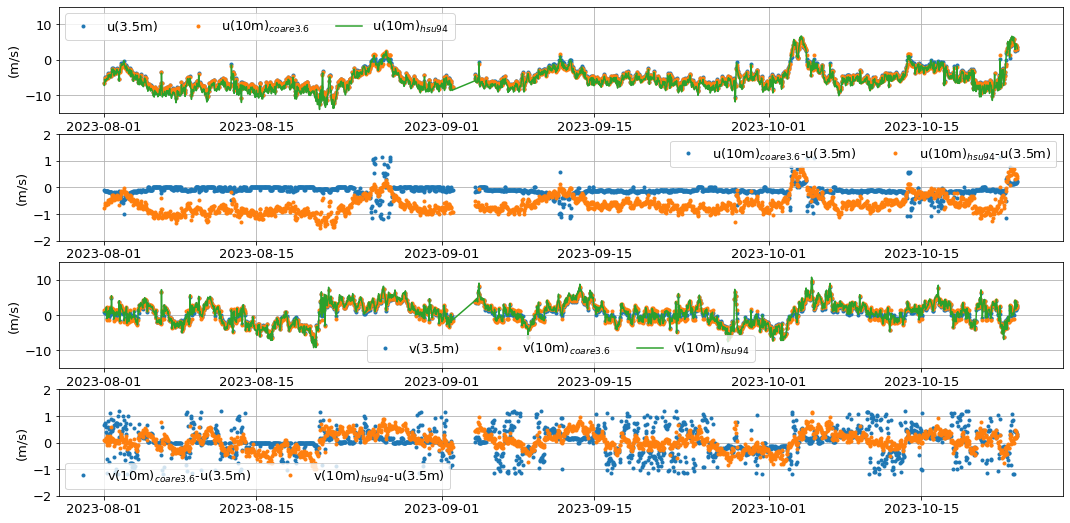

In [4]:
''' plot the different wind velocities '''
dtime_match = np.array([datetime.datetime.fromtimestamp(item) for item in data_match[:,0]])
nrow = 4; ncol = 1
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(nrows=nrow,ncols=ncol)
fig.set_size_inches(18, 9)
''' u '''
plt.subplot(nrow,ncol,1)
plt.plot(dtime_match, uwnd,'.', label='u(3.5m)')
# x = u_out[:,32].copy()
# x[uwnd_sign == -1] = -x[uwnd_sign == -1]
plt.plot(dtime_match, u10_coare,'.', label='u(10m)$_{coare3.6}$')
plt.plot(dtime_match, u10_hsu, label='u(10m)$_{hsu94}$')
''' du '''
plt.subplot(nrow,ncol,2)
plt.plot(dtime_match, u10_coare-uwnd, '.', label='u(10m)$_{coare3.6}$-u(3.5m)')
plt.plot(dtime_match, u10_hsu-uwnd, '.', label='u(10m)$_{hsu94}$-u(3.5m)')
''' v '''
plt.subplot(nrow,ncol,3)
plt.plot(dtime_match, vwnd,'.', label='v(3.5m)')
# x = v_out[:,32].copy()
# x[vwnd_sign == -1] = -x[vwnd_sign == -1]
plt.plot(dtime_match, v10_coare,'.', label='v(10m)$_{coare3.6}$')
plt.plot(dtime_match, v10_hsu, label='v(10m)$_{hsu94}$')
''' dv '''
plt.subplot(nrow,ncol,4)
plt.plot(dtime_match, v10_coare-vwnd, '.', label='v(10m)$_{coare3.6}$-u(3.5m)')
plt.plot(dtime_match, v10_hsu-vwnd, '.', label='v(10m)$_{hsu94}$-u(3.5m)')
''' plot settings '''
for i in range(nrow):
    plt.subplot(nrow,ncol,i+1)
    if i%2 == 0:
        plt.ylim([-15,15])
    else:
        plt.ylim([-2,2])
    plt.grid()
    plt.ylabel('(m/s)')
    plt.legend(loc='best',ncol=3)

''' save figure '''
# plt.savefig('uv_SD(3.5m)_adj_height_by_coare3.6_hsu94_'+year+'-SD'+platf_num+'.png',dpi=400,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

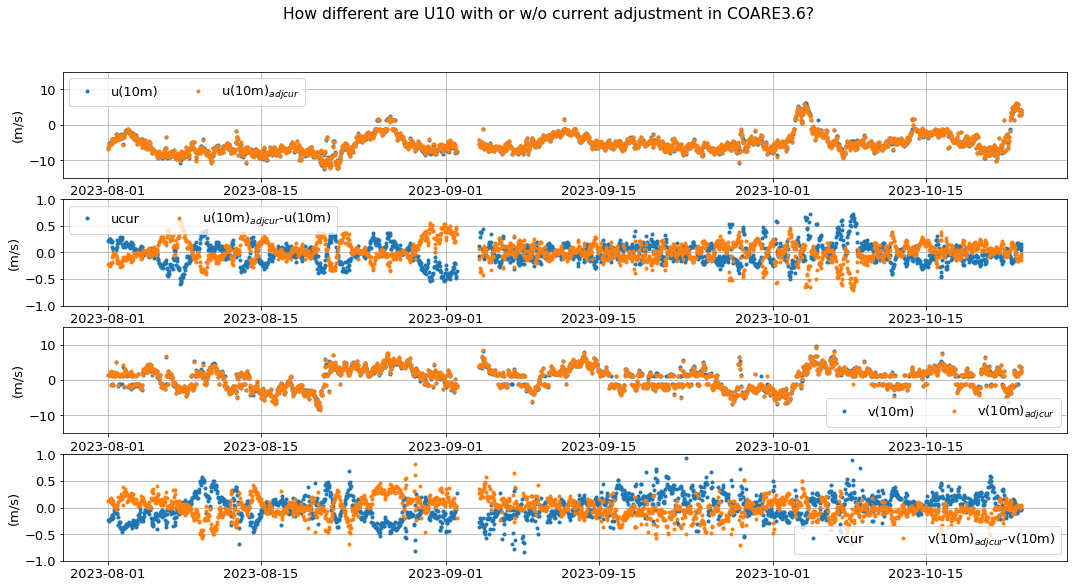

In [93]:
''' plot u10: (1) coare3.6 input u= uwnd, (2) coare3.6 input u= uwnd-ucur '''
uwnd_adj_cur_sign = np.sign(uwnd-ucur)
vwnd_adj_cur_sign = np.sign(vwnd-vcur) 
u_adj_cur_out = np.squeeze( coare36vn_zrf_et(u=np.abs(uwnd-ucur), zu=3.5, t=airT, zt=2.3, rh=rh, zq=2.3, P=bp, ts=sst, sw_dn=sw_dn, lw_dn=lw_dn, \
                                             lat=lat, lon=lon, jd=jd, zi=zi, rain=[0], Ss=sss, cp=None, sigH=None, zrf_u=10.0, zrf_q=10.0, zrf_t=10.0) )
v_adj_cur_out = np.squeeze( coare36vn_zrf_et(u=np.abs(vwnd-vcur), zu=3.5, t=airT, zt=2.3, rh=rh, zq=2.3, P=bp, ts=sst, sw_dn=sw_dn, lw_dn=lw_dn, \
                                             lat=lat, lon=lon, jd=jd, zi=zi, rain=[0], Ss=sss, cp=None, sigH=None, zrf_u=10.0, zrf_q=10.0, zrf_t=10.0) )
''' plot '''
nrow = 4; ncol = 1
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(nrows=nrow,ncols=ncol)
fig.set_size_inches(18, 9)
''' u '''
plt.subplot(nrow,ncol,1)
x = u_out[:,32].copy()
x[uwnd_sign == -1] = -x[uwnd_sign == -1]
plt.plot(dtime_match, x, '.', label='u(10m)')
y = u_adj_cur_out[:,32].copy()
y[uwnd_adj_cur_sign == -1] = -y[uwnd_adj_cur_sign == -1]
plt.plot(dtime_match, y, '.', label='u(10m)$_{adj cur}$')
''' du '''
plt.subplot(nrow,ncol,2)
plt.plot(dtime_match, ucur, '.', label='ucur')
plt.plot(dtime_match, y-x, '.', label='u(10m)$_{adj cur}$-u(10m)')
''' v '''
plt.subplot(nrow,ncol,3)
x = v_out[:,32].copy()
x[vwnd_sign == -1] = -x[vwnd_sign == -1]
plt.plot(dtime_match, x, '.', label='v(10m)')
y = v_adj_cur_out[:,32].copy()
y[vwnd_adj_cur_sign == -1] = -y[vwnd_adj_cur_sign == -1]
plt.plot(dtime_match, y, '.', label='v(10m)$_{adj cur}$')
''' dv '''
plt.subplot(nrow,ncol,4)
plt.plot(dtime_match, vcur, '.', label='vcur')
plt.plot(dtime_match, y-x, '.', label='v(10m)$_{adj cur}$-v(10m)')
''' plot settings '''
for i in range(nrow):
    plt.subplot(nrow,ncol,i+1)
    if i%2 == 0:
        plt.ylim([-15,15])
    else:
        plt.ylim([-1,1])
    plt.grid()
    plt.ylabel('(m/s)')
    plt.legend(loc='best',ncol=3)
plt.suptitle('How different are U10 with or w/o current adjustment in COARE3.6?')
''' save figure '''
plt.savefig('uv_SD(10m)_adj_height_compare-cur_by_coare3.6_'+year+'-SD'+platf_num+'.png',dpi=400,bbox_inches='tight')